In [1]:
#!/usr/bin/python3
import numpy as np
import pandas as pd
# import pyarrow as pa
# ! pip install --pre pandas==2.0.2 # ponerlo en la terminal
# print(pd.__version__)
# pd.options.mode.dtype_backend = 'pyarrow'
# pd.options.mode.data_manager="pyarrow"

# pd.options.mode.dtype_backend="pyarrow"

import matplotlib.pyplot as plt
import uproot
import sys
import yaml
from tqdm import tqdm # sirve para ver la linea de carga al cargar los archivos
import pint
import seaborn as sns
import mplhep as hep
hep.style.use(hep.style.ATLAS)
# import awkward as ak
# import vector

# DEFINICIONES UTILES

In [2]:
# Leer archivos de data_.yaml
def read_data_yaml(data_yaml_file):
    with open(data_yaml_file) as f:
        data_yaml = yaml.load(f, Loader=yaml.FullLoader)
    return data_yaml

In [3]:
#Leer archivos root
def read_root_file(path, filename, tree_name):
    file = uproot.open(path + filename)
    tree = file[tree_name]
    return tree

In [4]:
#Se define la función con la que se escalan las variables para transformar unidades.
def scale_df(df, scale):
    for variable in scale:
        df[variable] = df[variable]*scale[variable]
    return df

In [5]:
# crea una lista con todos los datasets introducidos en datasets
def read_datasets(vbf_data, ggf_data, variables, scale, path):
    df_all = pd.DataFrame()
    df_all_signal = pd.DataFrame()
    df_all_background = pd.DataFrame()

    # se leen los df's introducidos en datasets
    for data in tqdm(vbf_data): 
        datos = read_root_file(path, data, "miniT")
        df_data = datos.arrays(variables, library="pd")
        df_data = scale_df(df_data, scale)

        # guardo el nombre del dataset 
        nombre = data.split('.', 1)[0] # elimino lo de despues del punto
        nombre = nombre.split('/', 1)[1] # elimino lo de antes del punto
        df_data.columns.name = nombre # le doy el nombre al dataframe

        # añado llaves para diferenciar los dataframes
        df_data["df_name"] = nombre
        df_data["origin"] = "VBF"

        # se guarda el df en la lista
        df_all_signal = pd.concat([df_all_signal, df_data], axis=0)
    
    # se leen los df's introducidos en datasets
    for data in tqdm(ggf_data): 
        datos = read_root_file(path, data, "miniT")
        df_data = datos.arrays(variables, library="pd")
        df_data = scale_df(df_data, scale)

        # guardo el nombre del dataset 
        nombre = data.split('.', 1)[0] # elimino lo de despues del punto
        nombre = nombre.split('/', 1)[1] # elimino lo de antes del punto
        df_data.columns.name = nombre # le doy el nombre al dataframe

        # añado llaves para diferenciar los dataframes
        df_data["df_name"] = nombre
        df_data["origin"] = "ggF"

        # se guarda el df en la lista
        df_all_background = pd.concat([df_all_background, df_data], axis=0)
    
    df_all = pd.concat([df_all_signal, df_all_background], axis=0)
    df_all.set_index(['origin', 'df_name'], inplace=True)
    return df_all

In [6]:
#Se le da el corte
# se realizan los cortes superiores e inferiores a una lista de dataframes
def do_cuts(df_all, cuts, scale):
    # nombre de la señal a la cual se le mostrará el número de eventos
    name_signal = df_all.index.get_level_values('df_name').unique()[0]

    # se aplican todos los cortes
    for variable in cuts:
        # se grafica el numero de eventos
        numero_eventos_antes = df_all.query('df_name == @name_signal').shape[0]
        print(f'Numero eventos antes: {numero_eventos_antes}')
        
        #Definimos si el corte es un booleano. Se ocupa cuando se quieren cortar cosas del estilo Triggers
        if type(cuts[variable]) == type(True):
            print(f'Corte: {variable} == {cuts[variable]}')
            df_all = df_all[df_all[variable] == cuts[variable]]

            
        #Definimos si el corte es una lista, esto se ocupa para cuando se quieren cortar máximos y mínimos.   
        elif type(cuts[variable]) == type([]):
            corte_menor = cuts[variable][0]*scale[variable]
            corte_mayor = cuts[variable][1]*scale[variable]
            
            print(f'Corte: {variable} entre {cuts[variable]}')
            df_all = df_all[df_all[variable] < corte_mayor]
            df_all = df_all[df_all[variable] > corte_menor]

        
        #Definimos si el corte es un número entero. Se ocupa para cuando queremos separar los datos que tienen que ser un valor específico como un veto.
        elif type(cuts[variable]) == type(0):
            print(f'Corte: {variable} == {cuts[variable]}')
            df_all = df_all[df_all[variable] == cuts[variable]]


        # elif type(cuts[variable]) == type(''):
        #     print(f'Corte: {variable} == {cuts[variable]}')
        #     df_all = df_all[df_all[variable] == cuts[variable]]
            
        else:
            print("ADVERTENCIA: NO TOMA LA VARIABLE DEL CORTE")

        numero_eventos_despues = df_all.query('df_name == @name_signal').shape[0]
        print(f'Numero eventos antes: {numero_eventos_despues} \n')
    
    # elimino los pesos negativos
    # weights = df_all["intLumi"]*df_all["scale1fb"]
    df_all = df_all[df_all["intLumi"]*df_all["scale1fb"] >= 0]
             
    return df_all

# CALCULO FORMULAS

In [7]:
################################################################################
############################### SIGNIFICANCIA ##################################
################################################################################
# SIGNIFICANCE DEFINITION
def significance(df_all):

    df_signal = df_all.query('origin == "signal"')
    df_background = df_all.query('origin == "background"')
    if df_signal.empty:
        # No hay datos de señal
        signal_weight = 0
    else:
        signal_weight = (df_all.loc['signal']["intLumi"]*df_all.loc['signal']["scale1fb"]).sum()

    if df_background.empty:
        # No hay datos de background
        backgrounds_weight = np.nan
    else:
        backgrounds_weight = (df_all.loc['background']["intLumi"]*df_all.loc['background']["scale1fb"]).sum()

    # se calcula la significancia con la fórmula proporcionada
    return np.sqrt(2 * abs( (signal_weight + backgrounds_weight) * np.log(1 + (signal_weight/backgrounds_weight)) - signal_weight))



def barrido_significancia_variable(df_all, variable, derecha = True):
    n_cuts = 100 # numero_iteraciones_cortes
    valores_significancia_variable = [] # lista donde se guardan las eficiencias 
    valores_cortes = [] # lista donde se guardan los cortes realizados

    valor_minimo = df_all.loc["signal"][variable].min()
    valor_maximo = df_all.loc["signal"][variable].max()

    df_original = df_all

    # se realiza el barrido de cortes, y se calcula la significancia para cada corte
    for i in range(n_cuts):
        # hago un corte a signal que va aumentando en cada iteracion
        iteration_cut = valor_minimo + i*(valor_maximo-valor_minimo)/n_cuts
        
        if derecha==True:
            df_all = df_original[df_original[variable]>iteration_cut]
        else:
            df_all = df_original[df_original[variable]<iteration_cut]

        # si me quedo sin datos en el signal paro la simulación
        # if df_all.shape[0] == 0:
        #     break
            
        # se calcula la significancia con los nuevos cortes
        significancia_i = significance(df_all)

        # se guarda la significancia y su corte respectivo
        valores_significancia_variable.append(significancia_i)
        valores_cortes.append(iteration_cut)
        
    return valores_cortes, valores_significancia_variable


In [8]:
################################################################################
################################ EFICIENCIA ####################################
################################################################################

def efficiency(df, df_cut):
    eficiencia = df_cut.shape[0]/df.shape[0]
    return eficiencia



def barrido_eficiencia_variable(df, variable, derecha = True):
    n_cuts = 100 # numero_iteraciones_cortes
    valores_eficiencias_variable = [] # lista donde se guardan las eficiencias 
    valores_cortes = [] # lista donde se guardan los cortes realizados
    n_datos = [] # lista que va a guardar la cantidad de elementos de dataframe
    # n_datos.append(df.shape[0])

    valor_minimo = df[variable].min()
    valor_maximo = df[variable].max()

    # se realiza el barrido de cortes, y se calcula la significancia para cada corte
    for i in range(n_cuts):
        # hago un corte a signal que va aumentando en cada iteracion
        iteration_cut = valor_minimo + i*(valor_maximo-valor_minimo)/n_cuts
        
        if derecha==True:
            df_cut = df[df[variable]>iteration_cut]
        else:
            df_cut = df[df[variable]<iteration_cut]

        # si me quedo sin datos en el signal paro la simulación
        # if df.shape[0] == 0:
        #     break

        # se calcula la significancia con los nuevos cortes
        eficiencia_i = efficiency(df, df_cut)

        # se guarda la significancia y su corte respectivo
        valores_eficiencias_variable.append(eficiencia_i)
        valores_cortes.append(iteration_cut)
        n_datos.append(df_cut.shape[0])
        
    # Se devuelve un DataFrame con dos columnas
    df_eficiencias = pd.DataFrame({
        'n_datos': n_datos,
        'cortes': valores_cortes,
        'eficiencias': valores_eficiencias_variable
    })

    return df_eficiencias
    # return [valores_cortes, valores_eficiencias_variable]

def calc_eficiencias(df_all, variable, derecha = True):
    df_eficiencias = df_all.groupby(["origin", "df_name"]) \
                            .apply(lambda grupo: barrido_eficiencia_variable(grupo, variable, derecha))
    return df_eficiencias

In [9]:
################################################################################
################################ BK REJECTION ##################################
################################################################################


def calc_bk_rejection(df_all, variable, derecha = True):
    df_eficiencias = calc_eficiencias(df_all, variable, derecha)
    df_eficiencias['bk_rejection'] = 1 - df_eficiencias['eficiencias']
    return df_eficiencias



def calc_bk_rejection_all_background(df_all, variable, derecha = True):
    df_background = df_all.query('origin == "background"')
    df_eficiencias = barrido_eficiencia_variable(df_background, variable, derecha)
    df_eficiencias['bk_rejection'] = 1 - df_eficiencias['eficiencias']
    return df_eficiencias

In [10]:
################################################################################
################################### WEIGHT #####################################
################################################################################

def calc_weight(df):
    df_weight = df["intLumi"]*df["scale1fb"]
    return df_weight

# def aplicar_weight(df_all, variable):
#     df_all[variable] = df_all[variable]*calc_weight(df_all)
# PREGUNTAR SI SE APLICA A TO-DO O SOLO ES PARA GRAFICAR

# GRAFICAR

In [11]:
################################################################################
################################# GRAFICAR #####################################
################################################################################



def graficar(df_all, variable, derecha = True, graficar_significancia = True, graficar_eficiencia = True, aplicar_weights = True):

    # configuraciones para el gráfico
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams['font.size'] = 24 # estaba en 14
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = "serif"
    plt.style.use('classic')


    ################# ELIJO LA FORMA DEL GRAFICO DEPENDIENDO LO QUE QUEREMOS GRAFICAR ################


    if ((graficar_eficiencia == True) and (graficar_significancia == True)):
        fig, axes = plt.subplots(3,1, figsize=(10,12), sharex=True, sharey=False,  gridspec_kw={'height_ratios': [2.5, 1.2, 1.2]})
        #fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        #fig.tight_layout(fig)
        
        ###################################### TO DO : ################################
        ###################### CORREGIR LOS BORDES DEL GRAFICO #######################
        
        eje_histograma = axes[0]
        eje_significancia = axes[1]
        eje_eficiencia = axes[2]

    elif ((graficar_eficiencia == False) and (graficar_significancia == False)):
        fig, axes = plt.subplots(1,1, figsize=(10,12), sharex=True, sharey=False)
        eje_histograma = axes

    elif ((graficar_eficiencia == True) and (graficar_significancia == False)):
        fig, axes = plt.subplots(2,1, figsize=(10,12), sharex=True, sharey=False)
        eje_histograma = axes[0]
        eje_eficiencia = axes[1]
    
    else: # ((graficar_eficiencia == False) and (graficar_significancia == True))
        fig, axes = plt.subplots(2,1, figsize=(10,12), sharex=True, sharey=False)
        eje_histograma = axes[0]
        eje_significancia = axes[1]


    ################## MODIFICACION DATOS PARA GRAFICAR ##########################


    # pocentajes 
    porcentaje_bajo = 0.02
    porcentaje_alto = 0.98

    # elimino los valores extremos de df_all
    low_data = df_all.loc["signal"][variable].quantile(porcentaje_bajo)
    high_data  = df_all.loc["signal"][variable].quantile(porcentaje_alto) 
    df_all = df_all[(df_all[variable]>low_data) & (df_all[variable]<high_data)]

    best_cut_eficiencia = find_best_cut(df_all, variable, "eficiencia", derecha)
    best_cut_significancia = find_best_cut(df_all, variable, "significancia", derecha)


    ################## GRAFICO DE SIGNIFICANCIA ##########################


    if graficar_significancia == True:
        # calculo la significancia de la variable introducida
        cortes, significancia_variable = barrido_significancia_variable(df_all, variable, derecha)
        #Scatter de la significancia.
        scatter_significancia = sns.scatterplot(ax = eje_significancia, x = cortes, y = significancia_variable, marker=(8,2,0), color='coral', s=75) #Grafico pequeño
        scatter_significancia.set_xlabel(variable, fontdict={'size':12})
        scatter_significancia.set_ylabel('Significance', fontdict={'size':12})
        scatter_significancia.axvline(x = best_cut_significancia, color = 'red', label = 'corte significancia')
 

    # datos previos de los histogramas
    # color_palette = sns.color_palette("hls", len(backgrounds))
    # my_binwidth = (df_all.loc["signal"][variable].max() - df_all.loc["signal"][variable].min())/100.
    n_bins = 50

    ################## HISTOGRAMA DE LOS DATOS ##########################
    # if aplicar_weights == True:
    #     weight_signal = calc_weight(signal)
    # else:
    #     weight_signal = np.ones(signal.shape[0])


    histoplot = sns.histplot(ax=eje_histograma, 
                             data=df_all, 
                             x=variable, 
                             hue=df_all.index.get_level_values('df_name'),
                             legend=True,
                             alpha=0.05,  
                             stat='density', 
                             common_norm=False, 
                             binrange=(df_all.loc["signal"][variable].min(), df_all.loc["signal"][variable].max()), 
                             binwidth = (df_all.loc["signal"][variable].max() - df_all.loc["signal"][variable].min())/n_bins,  
                             weights=calc_weight(df_all), 
                             element="step", 
                            #  fill=False,
                             )
    

    #se ponen labels y legends en el grafico
    histoplot.set_xlabel(str(variable), fontdict={'size':12})
    histoplot.set_ylabel('Normalised Events for ' + str(variable) , fontdict={'size':12})
    histoplot.ticklabel_format(style='plain', axis='y')
    histoplot.axvline(x = best_cut_significancia, color = 'red', label = 'corte significancia')
    histoplot.axvline(x = best_cut_eficiencia, color = 'blue', label = 'corte significancia')


    ################## GRAFICO DE EFICIENCIA ##########################
    # color_palette = sns.color_palette("hls", len(backgrounds))
    if graficar_eficiencia == True:

        ######################### EFICIENCIA ##########################
        
        eficiencias_signal = calc_eficiencias(df_all, variable, derecha).query('origin=="signal"')
        scatter_eficiencia = sns.scatterplot(ax = eje_eficiencia, 
                                             data=eficiencias_signal, 
                                             x = "cortes", 
                                             y = "eficiencias", 
                                             color = 'black', 
                                            #  hue=df_eficiencias.index.get_level_values('df_name'),
                                             #legend=True,
                                             marker=(8,2,0), 
                                             s=75)


        # modificaciones graficos eficiencias
        scatter_eficiencia.set_xlabel(variable, fontdict={'size':12})
        scatter_eficiencia.set_ylabel('Efficiency', fontdict={'size':12})
        
        ######################### REJECTION ##########################

        # calculo y grafico el background rejection de signal
        bk_rejection_background = calc_bk_rejection(df_all, variable, derecha).query('origin == "background"')
        sns.scatterplot(data=bk_rejection_background, 
                        x="cortes", 
                        y="bk_rejection", 
                        # color = 'black', 
                        hue=bk_rejection_background.index.get_level_values('df_name'),
                        #label = "bk rejection signal",
                        #legend=True, 
                        marker=(8,2,0), 
                        s=30
                        )

        # calculo el background rejection de todos los backgrounds unidos
        bk_rejection_all_background = calc_bk_rejection_all_background(df_all, variable, derecha)
        sns.scatterplot(data=bk_rejection_all_background, 
                        x="cortes", 
                        y="bk_rejection", 
                        color = 'black', 
                        # hue=bk_rejection_background.index.get_level_values('df_name'),
                        #label = "bk rejection signal",
                        #legend=True, 
                        marker=(8,2,0), 
                        s=30
                        )
        
        # grafico de la linea de corte
        scatter_eficiencia.axvline(x = best_cut_eficiencia, color = 'blue', label = 'corte eficiencia')
        
        ####################### BARRAS DE ERROR ##########################
        #Calculo la desviación estándar de la lista eficiencia y se agregan al gráfico de eficiencia.
        # std = np.std(eficiencia_variable)
        plt.errorbar(x = eficiencias_signal["cortes"], 
                     y = eficiencias_signal["eficiencias"], 
                     yerr = np.sqrt(1/eficiencias_signal["n_datos"]), # multiplicar por desviacion estandar?, tendría que guardarla en la funcion de las eficiencias
                     fmt='none', 
                     linestyle='none')
        #plt.xlim(0,1000)
    
    
    
    #plt.savefig('complete_Graph1_MET.eps', format = 'eps')
    #plt.savefig('complete_Graph1_MET.pdf', format = 'pdf')
    #plt.legend()
    plt.show()

    ############## VIOLIN PLOT ####################
    # sns.violinplot(data=df_all, x=variable, y=df_all.index.get_level_values('df_name'))
    # plt.show()

    ############## PIE PLOT ####################
    # df_all.groupby(level='origin').size().plot(kind='pie', autopct='%1.1f%%', startangle=90)
    # plt.show()

# CORTES

In [12]:

################################################################################
############################### FIND BEST CUT ##################################
################################################################################


def find_best_cut(df_all, variable, method, derecha = True):
    if method == "significancia":
        cortes, significancia_variable = barrido_significancia_variable(df_all, variable, derecha)
        index_max_significance = significancia_variable.index(max(significancia_variable))
        maximo_corte = cortes[index_max_significance]
        return maximo_corte
        
    if method == "eficiencia":
        eficiencias_signal = calc_eficiencias(df_all, variable, derecha).query('origin=="signal"')["eficiencias"]

        bk_rejection = calc_bk_rejection_all_background(df_all, variable, derecha)
        bk_rejection_bk = bk_rejection["bk_rejection"]

        diferencia = abs(bk_rejection_bk.reset_index(drop=True)-eficiencias_signal.reset_index(drop=True))
        indice_minima_diferencia = diferencia.idxmin()
        corte_interseccion = bk_rejection["cortes"][indice_minima_diferencia]
        
        return corte_interseccion



################################################################################
################################# TESTING CUT ##################################
################################################################################

# se realizan los cortes superiores e inferiores a una lista de dataframes
def test_cuts(df_all, cuts, scale):

    df_original = df_all

    significancias = []
    eficiencias = []
    cortes = []
    variables = []
    n_datos = []
    n_datos_signal = []
    n_datos_background = []
    peso_signal = []

    significancias.append(significance(df_all))
    eficiencias.append(efficiency(df_all, df_all))
    cortes.append(0)
    variables.append("")
    n_datos.append(df_all.shape[0])
    n_datos_signal.append(df_all.query('origin=="signal"').shape[0])
    n_datos_background.append(df_all.query('origin=="background"').shape[0])
    peso_signal.append((df_all.query('origin=="signal"')["intLumi"]*df_all.query('origin=="signal"')["scale1fb"]).sum())

    print(f'datos antes corte: {n_datos[-1]}')
    print(f'datos background antes corte: {n_datos_background[-1]}')
    print(f'datos signal antes corte: {n_datos_signal[-1]}')
    print(f'peso signal antes corte: {peso_signal[-1]} \n')

    # si se queda vacío puedo usar este para devolver las etiquetas
    df_recover_bk = df_all.query('origin=="background"').iloc[:2]*0 
    df_recover_sg = df_all.query('origin=="signal"').iloc[:2]*0

    # se aplican todos los cortes
    for variable in cuts:

        #Definimos si el corte es un booleano. Se ocupa cuando se quieren cortar cosas del estilo Triggers
        if type(cuts[variable]) == type(True):
            print(f'Corte: {variable} == {cuts[variable]}')
            df_all = df_all[df_all[variable] == cuts[variable]]

            
        #Definimos si el corte es una lista, esto se ocupa para cuando se quieren cortar máximos y mínimos.   
        elif type(cuts[variable]) == type([]):
            corte_menor = cuts[variable][0]*scale[variable]
            corte_mayor = cuts[variable][1]*scale[variable]
            
            print(f'Corte: {variable} entre {cuts[variable]}')
            df_all = df_all[df_all[variable] < corte_mayor]
            df_all = df_all[df_all[variable] > corte_menor]

        
        #Definimos si el corte es un número entero. Se ocupa para cuando queremos separar los datos que tienen que ser un valor específico como un veto.
        elif type(cuts[variable]) == type(0):
            print(f'Corte: {variable} == {cuts[variable]}')
            df_all = df_all[df_all[variable] == cuts[variable]]


        elif type(cuts[variable]) == type(''):
            print(f'Corte: {variable} == {cuts[variable]}')
            df_all = df_all[df_all[variable] == cuts[variable]]
            
        else:
            print("ADVERTENCIA: NO TOMA LA VARIABLE DEL CORTE")
             
    
        #
        # si alguno queda vacío vuelvo a poner elementos con las etiquetas, pero de valor 0, y después paro el código
        #

        df_signal = df_all.query('origin == "signal"')
        df_background = df_all.query('origin == "background"')

        if df_signal.empty:
            # No hay datos de señal
            print("Quedamos sin datos de señal")
            df_all = pd.concat([df_all, df_recover_sg])

        if df_background.empty:
            # No hay datos de background
            print("Quedamos sin datos de background")
            df_all = pd.concat([df_all, df_recover_bk])

        # guardamos los datos
        significancias.append(significance(df_all))
        eficiencias.append(efficiency(df_original, df_all))
        cortes.append(df_all[variable])
        variables.append(variable)
        n_datos.append(df_all.shape[0])
        n_datos_signal.append(df_all.query('origin=="signal"').shape[0])
        n_datos_background.append(df_all.query('origin=="background"').shape[0])
        peso_signal.append((df_all.query('origin=="signal"')["intLumi"]*df_all.query('origin=="signal"')["scale1fb"]).sum())

        # se para el código
        if df_signal.empty:
            break

        if df_background.empty:
            break

        # print(f'datos despues corte: {n_datos[-1]}')
        # print(f'datos background despues corte: {n_datos_background[-1]}')
        # print(f'datos signal despues corte: {n_datos_signal[-1]}')
        # print(f'peso signal despues corte: {peso_signal[-1]} \n')

        

    
    df_data = pd.DataFrame({
        #'cortes': cortes,
        'variables': variables,
        # 'n_datos': n_datos,
        'n_datos_background': n_datos_background,
        'n_datos_signal': n_datos_signal,
        'eficiencias': np.round(eficiencias, 3),
        'significancias': np.round(significancias, 3),
        'weights': peso_signal
    })
    
    print(df_data)

    ####### STACKED ############
    # sns.barplot(data = df_data, x = "variables", y = "n_datos")
    # df_data.plot(x='variables', kind='bar', stacked=True,
    #     title='Stacked Bar Graph by dataframe')
    # axes = df_data.plot.bar(rot=0, subplots=True)
    # axes[1].legend(loc=2)  
    
    ax1 = plt.subplot(1,1,1)
    w = 0.3
    
    #plt.xticks(), will label the bars on x axis with the respective country names.
    x = np.arange(df_data['variables'].shape[0])
    plt.xticks(x + w /2, df_data['variables'], rotation='vertical')

    cmap_rojo =plt.get_cmap("Reds")
    cmap_azul =plt.get_cmap("Blues")

    valores_normalizados_signal = (df_data['n_datos_signal']) / (df_data['n_datos_signal'].max())
    valores_normalizados_background = (df_data['n_datos_background']) / (df_data['n_datos_background'].max())

    cmap_azul_signal = cmap_azul(valores_normalizados_signal)
    cmap_rojo_background = cmap_rojo(valores_normalizados_background)

    # creo las barras del background
    background =ax1.bar(x, df_data['n_datos_background'], width=w, color=cmap_rojo_background, align='center', yerr=1/np.sqrt(df_data['n_datos_background']))
    
    # pongo los label de cada barra
    ax1.bar_label(background, labels=df_data['significancias'], label_type='edge', padding=40)
    ax1.bar_label(background, labels=df_data['eficiencias'], label_type='edge', padding=20)
    
    # pongo los porcentajes al centro
    porcentaje_signal = np.round((df_data['n_datos_signal']/(df_data['n_datos_signal'] + df_data['n_datos_background']) )*100, 1)
    porcentaje_background = np.round((df_data['n_datos_background']/(df_data['n_datos_signal'] + df_data['n_datos_background']) )*100, 1)
    ax1.bar_label(background, labels=porcentaje_background, label_type='center')

    # creo las barras de la señal
    ax2 = ax1.twinx()
    signal =ax2.bar(x + w, df_data['n_datos_signal'], width=w, color=cmap_azul_signal, align='center', yerr=1/np.sqrt(df_data['n_datos_signal']))
    
    # pongo el porcentaje del centro de signal
    ax2.bar_label(signal, labels=porcentaje_signal, label_type='center')

    # pongo los ejes logaritmicos
    ax1.set_yscale('log')
    ax2.set_yscale('log')

    #Set the Y axis label as GDP.
    plt.ylabel('N datos')
    #To set the legend on the plot we have used plt.legend()
    plt.legend([background, signal],['background', 'signal'])
    #To show the plot finally we have used plt.show().
    plt.show()

# XGBOOST

In [13]:
# funcion de xgboost que clasifica
from xgboost import XGBClassifier

# graficar el arbol de desiciones del modelo, rcparams es para que se vea HD
from xgboost import plot_tree
from matplotlib.pylab import rcParams

# medir que tan bueno es el modelo
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [33]:
def do_classification(df_all):
    df_ml = df_all
    df_ml = df_ml.droplevel('df_name')
    df_ml = df_ml.drop(['njet30', 'scale1fb', 'intLumi'], axis=1)
    df_ml = df_ml.reset_index(level='origin')
    df_ml = pd.get_dummies(df_ml, columns=['origin'], dtype=int)

    df_X = df_ml[["mjj", "detajj", "dphijj", "MET"]] # omito njet30, intlumi y scale1f
    df_y = df_ml[["origin_VBF"]]

    # separo entre datos de entrenamiento y datos de validacion
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2)#, random_state=123)
    # DESPUES PONER DATOS SET DE VALIDACION!

    # aqui se hace el machine learning, creo un modelo y lo entreno
    model = XGBClassifier()
    model.fit(X_train, y_train)

    # grafico las desiciones que tomo el arbol
    rcParams['figure.figsize'] = 200,500
    plot_tree(model)
    plt.show()

    # veo que tan bueno fue el modelo
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Precisión del modelo: {accuracy * 100:.2f}%')
    
    return [df_ml, model]

# MAIN

In [15]:
# DEFINICIONES BASICAS

import sys

path = "/home/tomilee/Desktop/Universidad/dark_photons/proyecto_investigacion/codigo/"
data_yaml = read_data_yaml('calo_param_fix.yaml')      #Parámetros del calo

In [16]:
########################################################
########### LECTURA DATOS PREVIOS YAML #################
########################################################

# de data_yaml obtenemos los nombres de los datasets
vbf_data = data_yaml['VBF'].values() #esto devuelve solo los valores de cada variable.
ggf_data = data_yaml['ggF'].values() #esto devuelve solo los valores de cada variable.

# de data_yaml obtenemos los nombres de las variables
variables = data_yaml['recover_branches']
# de data_yaml obtenemos las escalas de las variables
scales = data_yaml['scale_variable']

# de data_yaml obtenemos los nombres de los cortes y los valores de los cortes menores y mayores
cuts = data_yaml['cuts']

In [17]:
########################################################
############# LECTURA DATOS ROOT FILES #################
########################################################
df_all = read_datasets(vbf_data, ggf_data, variables, scales, path)

100%|██████████| 9/9 [00:16<00:00,  1.89s/it]


In [18]:
df_all


njet30          mjj      detajj   
origin df_name                                                        
VBF    samples/VBF/frvz_vbf_500757       2  1316.194214    5.130603  \
       samples/VBF/frvz_vbf_500757       7  2287.880371    7.156201   
       samples/VBF/frvz_vbf_500757       2  1568.506470    6.255918   
       samples/VBF/frvz_vbf_500757       4   471.740875    1.960242   
       samples/VBF/frvz_vbf_500757       8  1150.059692    4.557185   
...                                    ...          ...         ...   
ggF    samples/ggF/frvz_ggf_508893       1    -0.999000 -999.000000   
       samples/ggF/frvz_ggf_508893       3   240.689178    1.942230   
       samples/ggF/frvz_ggf_508893       2   143.422470    2.548514   
       samples/ggF/frvz_ggf_508893       0    -0.999000 -999.000000   
       samples/ggF/frvz_ggf_508893       0    -0.999000 -999.000000   

                                        dphijj         MET  scale1fb   
origin df_name                                                         
VBF    samples/VBF/frvz_vbf_500757    1.032967  177.043106  0.000486  \
       samples/VBF/frvz_vbf_500757   -2.580441  101.195091  0.000502   
       samples/VBF/frvz_vbf_500757   -1.375577  130.909744  0.000429   
       samples/VBF/frvz_vbf_500757    2.980181  491.291687  0.000531   
       samples/VBF/frvz_vbf_500757    2.197970  115.439743  0.000014   
...                                        ...         ...       ...   
ggF    samples/ggF/frvz_ggf_508893 -999.000000   40.554482  0.028479   
       samples/ggF/frvz_ggf_508893    0.768057   76.802452  0.029882   
       samples/ggF/frvz_ggf_508893    2.000947   26.644657  0.029517   
       samples/ggF/frvz_ggf_508893 -999.000000   10.709071  0.029929   
       samples/ggF/frvz_ggf_508893 -999.000000   10.808948  0.030318   

                                      intLumi  
origin df_name                                 
VBF    samples/VBF/frvz_vbf_500757  44.299999  
       samples/VBF/frvz_vbf_500757  44.299999  
       samples/VBF/frvz_vbf_500757  44.299999  
       samples/VBF/frvz_vbf_500757  44.299999  
       samples/VBF/frvz_vbf_500757  44.299999  
...                                       ...  
ggF    samples/ggF/frvz_ggf_508893  58.450001  
       samples/ggF/frvz_ggf_508893  58.450001  
       samples/ggF/frvz_ggf_508893  58.450001  
       samples/ggF/frvz_ggf_508893  58.450001  
       samples/ggF/frvz_ggf_508893  58.450001  

[4628576 rows x 7 columns]

In [19]:
########################################################
####################### CORTES #########################
########################################################
# pruebo como funcionan los cortes
# test_cuts(df_all, cuts, scales)
# hago los cortes definitivos
df_all_cut = do_cuts(df_all, cuts, scales)

Numero eventos antes: 59024
Corte: njet30 entre [1, inf]
Numero eventos antes: 59024 



In [20]:

    


########################################################
####################### GRÁFICOS #######################
########################################################
# ELIJO LA VARIABLE A GRAFICAR
# variable = "dphijj"
# variable = "LJjet1_timing"
# variable = "LJjet1_jvt"
# graficar(df_all_cut, variable, derecha=False,
#          graficar_significancia = True, 
#          graficar_eficiencia = True, 
#          aplicar_weights = True)

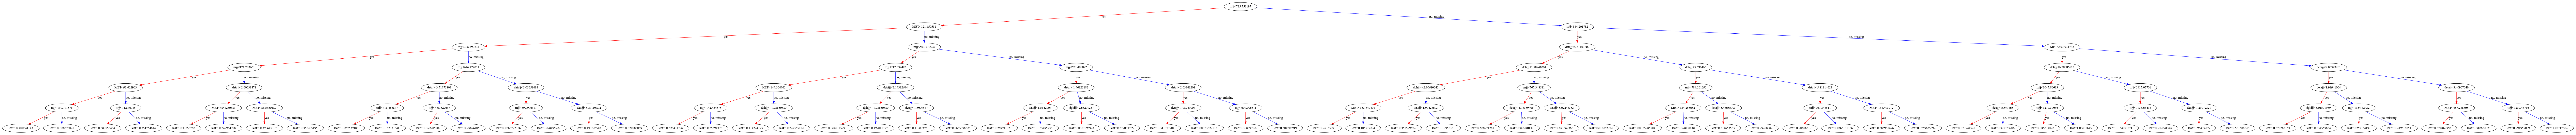

Precisión del modelo: 94.28%


In [34]:
########################################################
#################### CLASSIFICATION ####################
########################################################

df_ml = do_classification(df_all_cut)

In [35]:
df_ml[0]

,mjj,detajj,dphijj,MET,origin_VBF,origin_ggF
0,1316.194214,5.130603,1.032967,177.043106,1,0
1,2287.880371,7.156201,-2.580441,101.195091,1,0
2,1568.506470,6.255918,-1.375577,130.909744,1,0
3,471.740875,1.960242,2.980181,491.291687,1,0
4,1150.059692,4.557185,2.197970,115.439743,1,0
...,...,...,...,...,...,...
2012571,86.820213,0.779352,3.074377,36.471001,0,1
2012572,69.304848,0.293507,-2.302855,5.845552,0,1
2012573,506.555878,2.252506,-3.031298,27.214394,0,1
2012574,240.689178,1.942230,0.768057,76.802452,0,1
